In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Auto labeling based on video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos and then extract the bounding boxes for YOLO training with the output. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time
- extracting bounding boxes for YOLO training

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

This notebook is based on the example notebook from the SAM2 repository, which you can run to get more familiarized the the SAM2 features. To run it, use the following google colab badge:  
  
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

**NOTE**: the google colab functionality has not yet been implemented for this notebook.

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
# get path where this file is located
from notebooks.sam2_yolo_autolabel.yolo_utils import get_bounding_box, save_bboxes_to_yolo_format, read_yolo_labels 

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax, edgecolor='green'):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0, 0, 0, 0), lw=2))


def get_leading_zeros(s):
    leading_zeros = ''
    for char in s:
        if char == '0':
            leading_zeros += char
        else:
            break
    return leading_zeros

#### Extract frames of video

The video should be actually stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

To extract extract the frames for other videos, use ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -r 1 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-r 1` says to get 1 frame every second, `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`

### Select the frames and labels directory

is_first_run:  True
Running for first time, select the points in following cells
found 325 frames


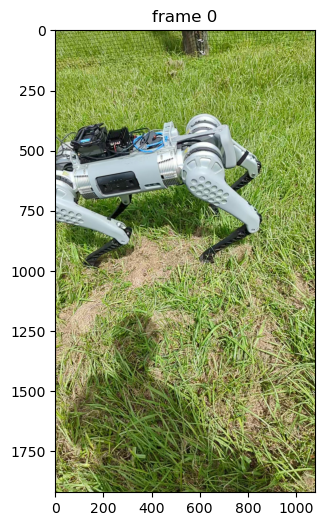

In [7]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/home/basestation/Documents/sam2/notebooks/videos/20241003_autonomy_park/20241003_autonomy_park_big_dog/batch_0"
labels_dir = "/home/basestation/Documents/sam2/notebooks/videos/20241003_autonomy_park/20241003_autonomy_park_big_dog_labels"
batch_num = int(video_dir[-1])
is_first_run = True if batch_num == 0 else False 
print("is_first_run: ", is_first_run)
if is_first_run:
    print("Running for first time, select the points in following cells")
else:
    print("Automatically getting bounding box of last frame")

# labels
if not os.path.exists(labels_dir):
    os.mkdir(labels_dir)

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
print(f"found {len(frame_names)} frames")
leading_zeros = get_leading_zeros(frame_names[0].split('.')[0])

if not is_first_run:
    # find the last frame in the last batch and include it in this batch
    last_frame_last_batch = int(frame_names[0].split('.')[0]) - 1
    print("starting frame: ", last_frame_last_batch)
    # move the image last_frame_last_batch.jpg from last batch to this batch
    os.rename(f"{video_dir}/../batch_" + str(batch_num - 1) + f"/{leading_zeros}{last_frame_last_batch}.jpg",
               f"{video_dir}/{leading_zeros}{last_frame_last_batch}.jpg")
    frame_names.insert(0, f"{leading_zeros}{last_frame_last_batch}.jpg")

# take a look the first video frame in this batch
frame_batch_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_batch_idx}") if is_first_run else plt.title(f"frame {frame_batch_idx + last_frame_last_batch}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_batch_idx])))

In [8]:
image_width, image_height = Image.open(os.path.join(video_dir, frame_names[0])).size
print(f"Image width: {image_width}, Image height: {image_height}")

Image width: 1080, Image height: 1920


#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [9]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:10<00:00, 31.13it/s]


Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [10]:
predictor.reset_state(inference_state)

SAM 2 can segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

Add the first object with a **positive click** on frame 0. There are also negative clicks, which are used to exclude regions from the mask.

We assign it to object id `0` (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the `add_new_points_or_box` API to distinguish the object we are clicking upon.

To include the following objects, keep including positive clicks with another object id. 
There is also the option to include positive clicks in another frame. See the example notebook in SAM2 on how to do this. 


/home/basestation/Documents/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/home/basestation/Documents/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


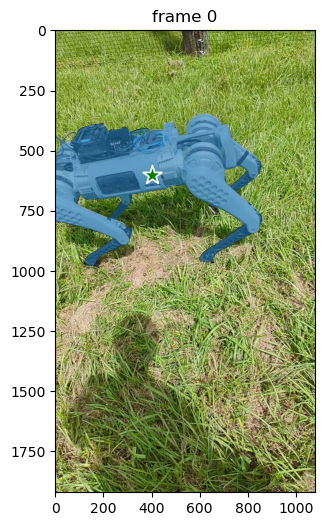

In [11]:
# yolo labels are 0: background, 1: drones, 2: ground vehicles 
# change the following dictionary to map the sam2 object id (key) to the yolo label id (value).  
obj_id_to_yolo_label = {0: 2,  
                        1: 2, 
                        2: 1, 
                        }

prompts = {}  # hold all the clicks we add for visualization

ann_frame_idx = 0  # the frame index we interact with

if is_first_run:

    ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)
    points = np.array([[400, 600]], dtype=np.float32)
    labels = np.array([1], np.int32)  # the label for each point, 1 for positive, 0 for negative
    prompts[ann_obj_id] = points, labels
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

    # if there are more than one object in frame, add more points or boxes

    # you can add more than one point (positive or negative) per object
    #points = np.array([[340, 170], [340, 140]], dtype=np.float32)
    #labels = np.array([1,1], np.int32)
    #prompts[ann_obj_id] = points, labels
    #_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    #    inference_state=inference_state,
    #    frame_idx=ann_frame_idx,
    #    obj_id=ann_obj_id,
    #    points=points,
    #    labels=labels,
    #)
else: 
    yolo_labels = read_yolo_labels(labels_dir + "/" + leading_zeros + str(last_frame_last_batch + ann_frame_idx) + '.txt', image_width, image_height)
    print("yolo_labels used to find object: ", yolo_labels)

    obj_index = 0
    for _, bbox in yolo_labels:
        box = np.array(bbox, dtype=np.float32)
        print(box)
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=obj_index,
            box=box,
        )
        obj_index += 1

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}") if is_first_run else plt.title(f"frame {ann_frame_idx + last_frame_last_batch}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
for i, out_obj_id in enumerate(out_obj_ids):
    if is_first_run:
        show_points(*prompts[out_obj_id], plt.gca())
    else:
        print(yolo_labels[i][1])
        show_box(yolo_labels[i][1], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

### Propagate Video

Now, we propagate the prompts for all objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:47<00:00,  6.90it/s]


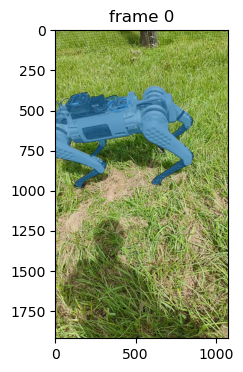

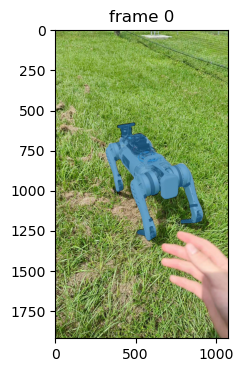

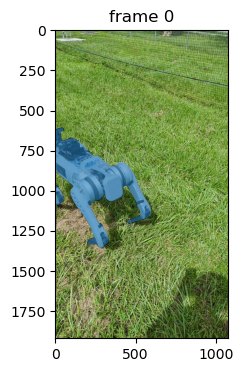

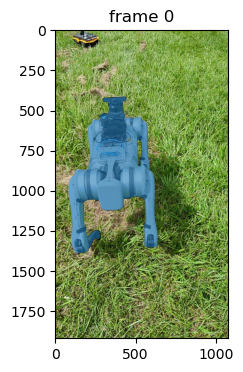

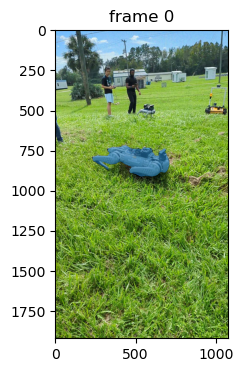

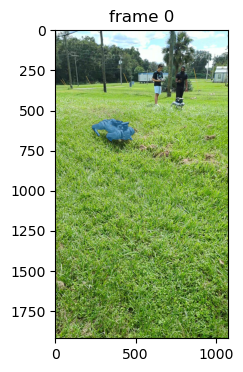

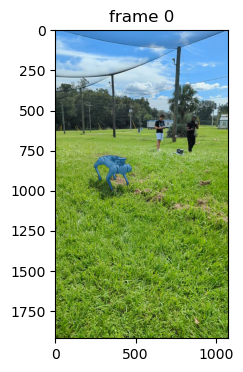

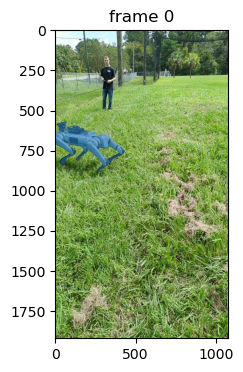

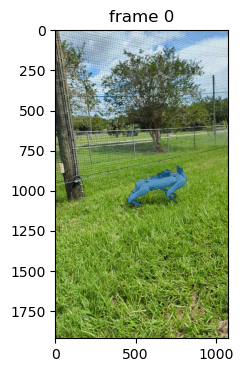

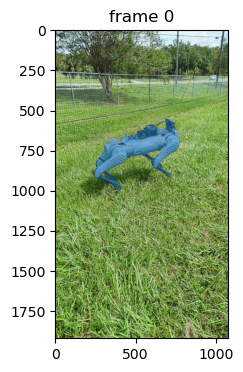

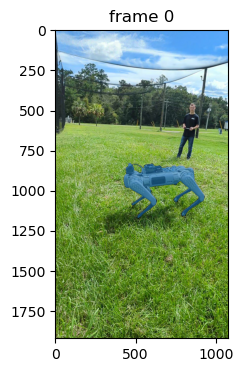

In [12]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
show_num_frames = 10
vis_frame_stride = len(frame_names) // show_num_frames
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {ann_frame_idx}") if is_first_run else plt.title(f"frame {out_frame_idx + last_frame_last_batch}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

### Extract yolo bounding boxes from segmentations

In [13]:
# assert length of video_segments is equal to the number of frames from frame_names
assert len(video_segments) == len(frame_names)
for frame_index, objects in video_segments.items():
    frame_name = frame_names[frame_index].split(".")[0]
    output_file = os.path.join(labels_dir, f"{frame_name}.txt")
    bboxes = []
    label_ids = [] 
    for obj_index, segmentation in objects.items():
        bboxes.append(get_bounding_box(segmentation[0]))
        label_ids.append(obj_id_to_yolo_label[obj_index])
    save_bboxes_to_yolo_format(image_width, image_height, bboxes, label_ids, output_file)

#### Confirm the bounding box output is correct

labels:  [(2, (0, 648, 988, 1674))]


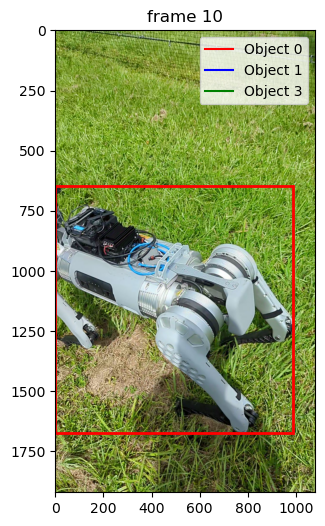

In [18]:
frame_batch_idx = 10  # pick any arbitrary frame in this batch to visualize the results

color = {0: 'red', 1: 'blue', 3: 'green'}  # for legend
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_batch_idx}") if is_first_run else plt.title(f"frame {frame_batch_idx + last_frame_last_batch}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_batch_idx])))
# determine how many zeroes to remove
if is_first_run:
    leng_idx = len(str(frame_batch_idx))
else:
    leng_idx= len(str(frame_batch_idx)) - len(str(last_frame_last_batch)) 
# remove the zeroes
if leng_idx >= 1:
    idx_leading_zeros = leading_zeros[:-leng_idx]
else: 
    idx_leading_zeros = leading_zeros
# read labels
if is_first_run:
    yolo_labels = read_yolo_labels(labels_dir + "/" + idx_leading_zeros + str(frame_batch_idx) + '.txt', image_width, image_height)
else: 
    yolo_labels = read_yolo_labels(labels_dir + "/" + idx_leading_zeros + str(frame_batch_idx + last_frame_last_batch) + '.txt', image_width, image_height)

print("labels: ", yolo_labels)
count = 0
for obj_index, segmentation in video_segments[frame_batch_idx].items():
    box = np.array(yolo_labels[count][1], dtype=np.float32)
    show_box(box, plt.gca(), edgecolor=color[obj_index])
    count += 1
# legend
for obj_index, c in color.items():
    plt.plot([], [], color=c, label=f"Object {obj_index}")
plt.legend()

## Second Batch

For the second batch and beyond, we can repeat the process above to add more objects and propagate them throughout the video but now
instead of manually selecting the objects, we will use the bounding boxes from the last frame of the previous batch, include it in 
this batch and propagate it throughout the video. 

The only step to do this is change the directory name to specify the batch will be greater than 0. Then, we will use the bounding boxes 
automatically. 

**NOTE**: you should **reset the notebook before** loading the second batch because if not the GPU will run out of memory. This is the reason we split the video frames in batches.